In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from dython.nominal import associations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from pycaret.regression import *
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from flaml import AutoML
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix
import joblib

In [ ]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# List of encodings to try
encodings = ['utf-8', 'latin-1', 'utf-16']

# Try reading the file with different encodings
for encoding in encodings:
    try:
        pitches_metadata = pd.read_csv('data/pitch_by_pitch_metadata.csv', encoding=encoding)
        # If reading is successful, break out of the loop
        break
    except UnicodeDecodeError:
        # If decoding fails, try the next encoding
        continue

pitches_metadata



,column_name,available_prior_to_pitch,description
0,uid,Yes,unique id
1,game_pk,Yes,unique game id
2,year,Yes,year
3,date,Yes,date
4,team_id_b,Yes,team_id for the batting team
5,team_id_p,Yes,team_id for the pitching team
6,inning,Yes,inning number
7,top,Yes,binary: is top half of inning
8,at_bat_num,Yes,incrementing at bat count for game
9,pcount_at_bat,Yes,pitches thrown in at bat


In [ ]:
# Read the CSV file
pitches_df = pd.read_csv('data/pitches', encoding='utf-8',low_memory=False)

pitches_df= pitches_df[['uid','game_pk','year','date','team_id_b','team_id_p','inning','top','at_bat_num','pcount_at_bat','pcount_pitcher','balls',
'strikes','fouls','outs','start_tfs','start_tfs_zulu','batter_id','stand','b_height','pitcher_id','p_throws','away_team_runs','home_team_runs',
'pitch_id','on_1b','on_2b','on_3b', 'pitch_type']]
# Display the data
pitches_df.head(10)

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,pitch_id,on_1b,on_2b,on_3b,pitch_type
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,1,0,0,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,3,NaN,NaN,NaN,NaN
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,2,1,0,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,4,NaN,NaN,NaN,NaN
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,3,2,0,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,5,NaN,NaN,NaN,NaN
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,4,2,1,0,0,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,0,0,6,NaN,NaN,NaN,NaN
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,5,0,0,0,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,10,NaN,NaN,NaN,NaN
5,14143231,286874,2011,2011-03-31,108,118,1,1,2,2,6,0,1,0,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,11,NaN,NaN,NaN,NaN
6,14143232,286874,2011,2011-03-31,108,118,1,1,2,3,7,1,1,0,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,12,NaN,NaN,NaN,NaN
7,14143233,286874,2011,2011-03-31,108,118,1,1,2,4,8,1,2,1,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,13,NaN,NaN,NaN,NaN
8,14143234,286874,2011,2011-03-31,108,118,1,1,2,5,9,2,2,1,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,14,NaN,NaN,NaN,NaN
9,14143235,286874,2011,2011-03-31,108,118,1,1,2,6,10,2,2,2,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,0,0,15,NaN,NaN,NaN,NaN


In [ ]:
pitches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718961 entries, 0 to 718960
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   uid             718961 non-null  int64  
 1   game_pk         718961 non-null  int64  
 2   year            718961 non-null  int64  
 3   date            718961 non-null  object 
 4   team_id_b       718961 non-null  int64  
 5   team_id_p       718961 non-null  int64  
 6   inning          718961 non-null  int64  
 7   top             718961 non-null  int64  
 8   at_bat_num      718961 non-null  int64  
 9   pcount_at_bat   718961 non-null  int64  
 10  pcount_pitcher  718961 non-null  int64  
 11  balls           718961 non-null  int64  
 12  strikes         718961 non-null  int64  
 13  fouls           718961 non-null  int64  
 14  outs            718961 non-null  int64  
 15  start_tfs       718961 non-null  int64  
 16  start_tfs_zulu  718961 non-null  object 
 17  batter_id 

In [ ]:
pitches_df.describe().T

,count,mean,std,min,25%,50%,75%,max
uid,718961.0,1.701980e+07,1.665143e+06,14143226.0,15573563.0,17031064.0,18458937.0,19838196.0
game_pk,718961.0,2.885576e+05,3.642211e+03,286874.0,287507.0,288129.0,288749.0,317073.0
year,718961.0,2.011000e+03,0.000000e+00,2011.0,2011.0,2011.0,2011.0,2011.0
team_id_b,718961.0,1.287872e+02,1.428104e+01,108.0,115.0,134.0,141.0,158.0
team_id_p,718961.0,1.287573e+02,1.430671e+01,108.0,115.0,134.0,141.0,158.0
inning,718961.0,5.033796e+00,2.692326e+00,1.0,3.0,5.0,7.0,19.0
top,718961.0,5.088996e-01,4.999211e-01,0.0,0.0,1.0,1.0,1.0
at_bat_num,718961.0,3.930151e+01,2.332072e+01,1.0,19.0,39.0,58.0,158.0
pcount_at_bat,718961.0,2.865276e+00,1.715068e+00,1.0,1.0,3.0,4.0,16.0
pcount_pitcher,718961.0,3.735720e+01,3.069057e+01,1.0,11.0,28.0,61.0,133.0


In [ ]:
pitches_df['pitch_type'].value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

In [ ]:
#Display how many null in each column
for col in pitches_df.columns:
    print(col, pitches_df[col].isnull().sum())

uid 0
game_pk 0
year 0
date 0
team_id_b 0
team_id_p 0
inning 0
top 0
at_bat_num 0
pcount_at_bat 0
pcount_pitcher 0
balls 0
strikes 0
fouls 0
outs 0
is_final_pitch 0
final_balls 0
final_strikes 0
final_outs 0
start_tfs 0
start_tfs_zulu 0
batter_id 0
stand 0
b_height 0
pitcher_id 0
p_throws 0
at_bat_des 0
event 0
event2 710662
event3 718627
event4 718938
away_team_runs 0
home_team_runs 0
score 662865
pitch_des 0
pitch_id 0
type 0
pitch_tfs 302
pitch_tfs_zulu 302
x 0
y 0
sv_id 2280
start_speed 2280
end_speed 2280
sz_top 2280
sz_bot 2280
pfx_x 2280
pfx_z 2280
px 2280
pz 2280
x0 2280
z0 2280
y0 2280
vx0 2280
vz0 2280
vy0 2280
ax 2280
az 2280
ay 2280
break_length 2280
break_y 2280
break_angle 2280
pitch_type 2280
type_confidence 2280
zone 2280
nasty 2280
spin_dir 2280
spin_rate 2280
cc 691024
on_1b 502638
on_2b 579258
on_3b 647326
runner1_id 718961
runner1_start 718961
runner1_end 718961
runner1_event 718961
runner1_score 718961
runner1_rbi 718961
runner1_earned 718961
runner2_id 718961
runn

# filter the features

In [ ]:
pitches_df.columns.to_list()

['uid',
 'game_pk',
 'year',
 'date',
 'team_id_b',
 'team_id_p',
 'inning',
 'top',
 'at_bat_num',
 'pcount_at_bat',
 'pcount_pitcher',
 'balls',
 'strikes',
 'fouls',
 'outs',
 'is_final_pitch',
 'final_balls',
 'final_strikes',
 'final_outs',
 'start_tfs',
 'start_tfs_zulu',
 'batter_id',
 'stand',
 'b_height',
 'pitcher_id',
 'p_throws',
 'at_bat_des',
 'event',
 'event2',
 'event3',
 'event4',
 'away_team_runs',
 'home_team_runs',
 'score',
 'pitch_des',
 'pitch_id',
 'type',
 'pitch_tfs',
 'pitch_tfs_zulu',
 'x',
 'y',
 'sv_id',
 'start_speed',
 'end_speed',
 'sz_top',
 'sz_bot',
 'pfx_x',
 'pfx_z',
 'px',
 'pz',
 'x0',
 'z0',
 'y0',
 'vx0',
 'vz0',
 'vy0',
 'ax',
 'az',
 'ay',
 'break_length',
 'break_y',
 'break_angle',
 'pitch_type',
 'type_confidence',
 'zone',
 'nasty',
 'spin_dir',
 'spin_rate',
 'cc',
 'on_1b',
 'on_2b',
 'on_3b',
 'runner1_id',
 'runner1_start',
 'runner1_end',
 'runner1_event',
 'runner1_score',
 'runner1_rbi',
 'runner1_earned',
 'runner2_id',
 'runner2

In [ ]:
#make copy of the main data
mlb_df=pitches_df.copy()
mlb_df= mlb_df[['inning','top','pcount_at_bat','pcount_pitcher','strikes','outs','start_tfs',
                     'pitcher_id','stand','b_height','p_throws', 'batter_id','start_tfs_zulu', 'pitch_type']]
mlb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718961 entries, 0 to 718960
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   inning          718961 non-null  int64 
 1   top             718961 non-null  int64 
 2   pcount_at_bat   718961 non-null  int64 
 3   pcount_pitcher  718961 non-null  int64 
 4   strikes         718961 non-null  int64 
 5   outs            718961 non-null  int64 
 6   start_tfs       718961 non-null  int64 
 7   pitcher_id      718961 non-null  int64 
 8   stand           718961 non-null  object
 9   b_height        718961 non-null  object
 10  p_throws        718961 non-null  object
 11  batter_id       718961 non-null  int64 
 12  start_tfs_zulu  718961 non-null  object
 13  pitch_type      716681 non-null  object
dtypes: int64(9), object(5)
memory usage: 76.8+ MB


## Check the existence of duplicate in the data

### Our data does not contain any duplicate

In [ ]:
# Check for duplicates
duplicates = mlb_df.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()
num_duplicates

0

In [ ]:
# Check for duplicates and display them
duplicates = mlb_df.duplicated(keep=False)
duplicate_rows = mlb_df[duplicates]

# Display the duplicate rows
print(duplicate_rows)


Empty DataFrame
Columns: [team_id_b, team_id_p, inning, top, at_bat_num, pcount_at_bat, pcount_pitcher, balls, strikes, fouls, outs, start_tfs, start_tfs_zulu, batter_id, stand, b_height, pitcher_id, p_throws, away_team_runs, home_team_runs, pitch_id, pitch_type]
Index: []


# Explore Target class/ data balance

In [ ]:
mlb_df.pitch_type.value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

## Feature Engineering

In [ ]:
import datetime
import time

def time_segmentation(df, col):
    time_value_lst = []
    for i in df[col]:
        if isinstance(i, str) and len(i.split()) > 1:
            x = time.strptime(i.split()[1], '%H:%M:%S')
            time_value_lst.append(datetime.timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds())
        else:
            time_value_lst.append(None)

    day_time_lst = []
    for time_val in time_value_lst:
        if time_val is None:
            day_time_lst.append('missing')
        elif 32400 <= time_val <= 39600:
            day_time_lst.append('morning')
        elif 39600 <= time_val <= 54000:
            day_time_lst.append('afternoon')
        elif 54000 <= time_val < 64800:
            day_time_lst.append('primetime')
        elif 64800 <= time_val < 72000:
            day_time_lst.append('evening')
        else:
            day_time_lst.append('other')

    return day_time_lst

mlb_df['time'] = time_segmentation(mlb_df, 'start_tfs_zulu')


In [ ]:
mlb_df.time.value_counts()

other        594497
evening       94582
primetime     29882
Name: time, dtype: int64

In [ ]:
# drop the extra columns
mlb_df=mlb_df.drop('start_tfs_zulu', axis=1)

#drop the null values in pitch_type
mlb_df= mlb_df.dropna()

In [ ]:
mlb_df.columns.to_list()

['inning',
 'top',
 'pcount_at_bat',
 'pcount_pitcher',
 'strikes',
 'outs',
 'start_tfs',
 'pitcher_id',
 'stand',
 'b_height',
 'p_throws',
 'batter_id',
 'pitch_type',
 'time']

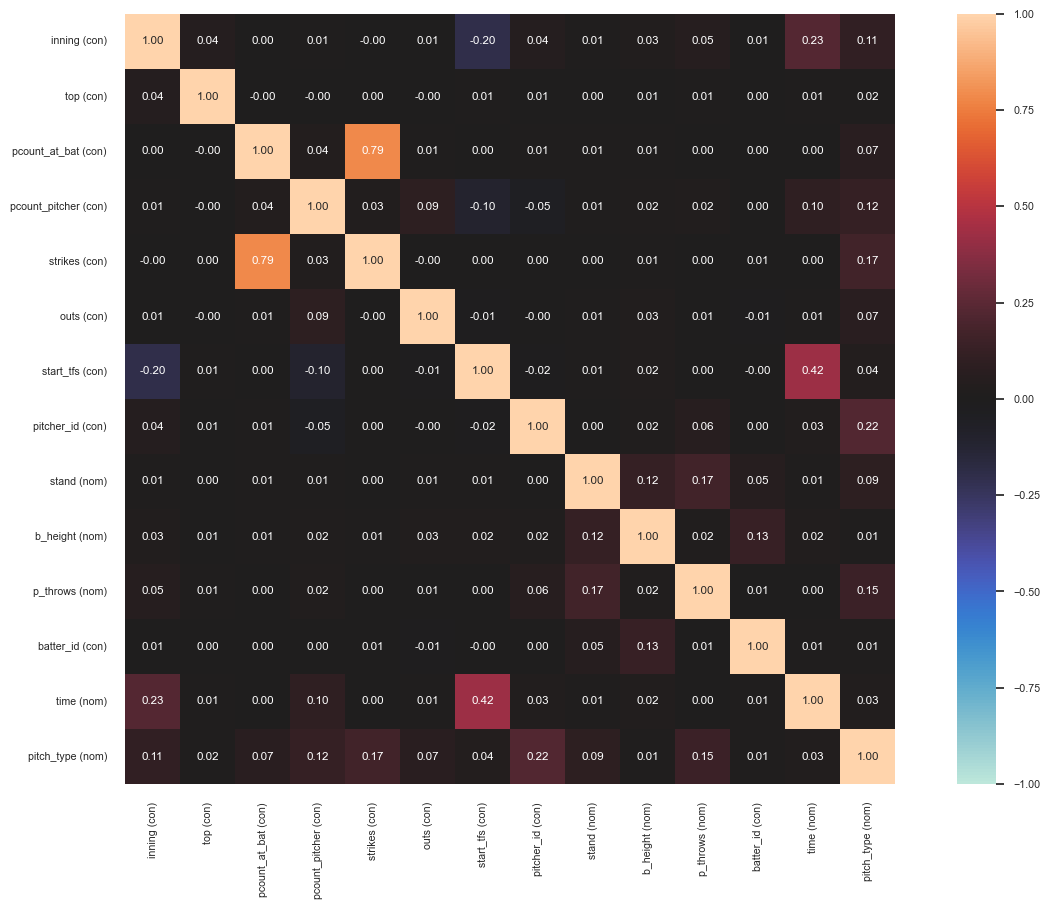

In [ ]:
# Build the correlation heatmap graph
sns.set(font_scale=0.7)
associations(mlb_df[['inning','top','pcount_at_bat','pcount_pitcher','strikes','outs','start_tfs','pitcher_id','stand',
                     'b_height','p_throws','batter_id','time', 'pitch_type']], figsize=(16, 10), nom_num_assoc='correlation_ratio', mark_columns=True)

plt.show()


# Handle the imbalanced data class

In [ ]:
mlb_df.pitch_type.value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

In [ ]:
# Drop of pitch type = [UN, AB] as they have small insight and that will dilute the model
mlb_df= mlb_df[(mlb_df.pitch_type != 'UN') & (mlb_df.pitch_type != 'AB')]

In [ ]:
# Select the categorical features to encode
categorical_features = ['stand', 'b_height', 'p_throws', 'time']

# Split the dataset into features (X) and target variable (y)
X = mlb_df.drop('pitch_type', axis=1)
y = mlb_df['pitch_type']

# Encode the categorical features using OneHotEncoder
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(X[categorical_features])

# Split the encoded features and remaining numerical features
X_encoded = encoded_features.toarray()
X_remaining = X.drop(categorical_features, axis=1)

# Combine the encoded features with the remaining numerical features
X_combined = np.hstack((X_encoded, X_remaining))

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Determine the number of neighbors based on the minority class
n_samples = len(y_encoded)
n_minority = np.sum(y_encoded == np.min(y_encoded))
n_neighbors = min(n_minority - 1, 5)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='not majority', k_neighbors=n_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_combined, y_encoded)



# SCALING the data

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
classes_name= label_encoder.classes_
classes_name

array(['CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 'KC',
       'KN', 'PO', 'SC', 'SI', 'SL'], dtype=object)

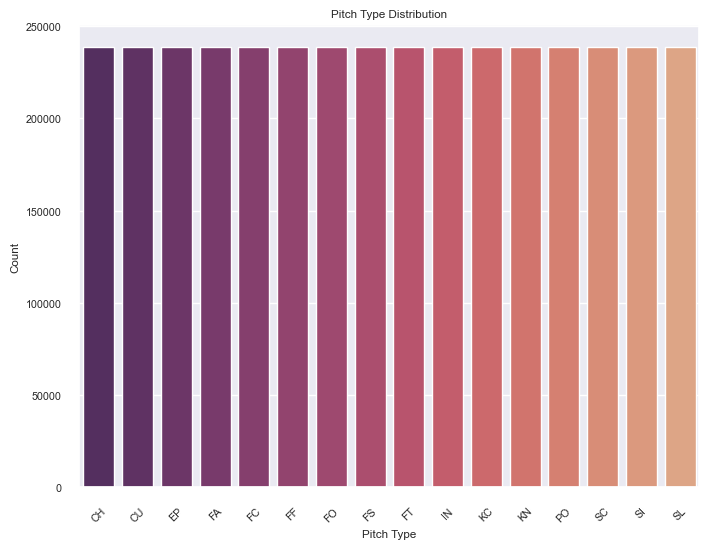

In [ ]:
import pandas as pd

# Create DataFrame for y_train
y_train_df = pd.DataFrame({'pitch_type': y_train})

# Create DataFrame for y_test
y_test_df = pd.DataFrame({'pitch_type': y_test})

# Concatenate y_train and y_test DataFrames
y_df = pd.concat([y_train_df, y_test_df])

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=y_df, x='pitch_type', palette='flare_r')
plt.title('Pitch Type Distribution')
plt.xlabel('Pitch Type')
plt.ylabel('Count')
plt.xticks(ticks=range(len(classes_name)),labels= classes_name, rotation=45)
plt.savefig("images/outliers.png",  bbox_inches='tight')

plt.show()


In [ ]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3053324, 34)

(3053324,)

(763332, 34)

(763332,)

In [ ]:
X_test[:50]

array([[0.00000000e+00, 1.00000000e+00, 9.34098161e-01, ...,
        6.59018394e-02, 1.31803679e-01, 1.16790306e+01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.09913042e+01, 5.00000000e+00, 5.76806519e+02],
       [8.37959812e-01, 1.62040188e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.83795981e+00, 2.32870232e+02],
       ...,
       [8.21479111e-01, 1.78520889e-01, 0.00000000e+00, ...,
        5.00000000e+00, 6.53556267e+00, 4.37142251e+02],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.16866812e+01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 3.40017002e+02]])

# Deep Learning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define the neural network model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/100
95417/95417 [==============================] - 212s 2ms/step - loss: 1.7688 - accuracy: 0.4174 - val_loss: 1.5680 - val_accuracy: 0.4780
Epoch 2/100
95417/95417 [==============================] - 167s 2ms/step - loss: 1.6812 - accuracy: 0.4417 - val_loss: 1.5422 - val_accuracy: 0.4866
Epoch 3/100
95417/95417 [==============================] - 156s 2ms/step - loss: 1.6628 - accuracy: 0.4468 - val_loss: 1.5380 - val_accuracy: 0.4846
Epoch 4/100
95417/95417 [==============================] - 205s 2ms/step - loss: 1.6549 - accuracy: 0.4492 - val_loss: 1.5179 - val_accuracy: 0.4908
Epoch 5/100
95417/95417 [==============================] - 181s 2ms/step - loss: 1.6484 - accuracy: 0.4511 - val_loss: 1.5167 - val_accuracy: 0.4881
Epoch 6/100
95417/95417 [==============================] - 218s 2ms/step - loss: 1.6456 - accuracy: 0.4520 - val_loss: 1.5142 - val_accuracy: 0.4898
Epoch 7/100
95417/95417 [==============================] - 180s 2ms/step - loss: 1.6413 - accuracy: 0.4533

# Running Pycaret to illustrate fearure importance, feature selection, model selection

In [ ]:
# init setup
from pycaret.classification import *

clf1 = setup(X_train, target = y_train)

,Description,Value
0,Session id,3590
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(3434990, 36)"
4,Transformed data shape,"(3434990, 36)"
5,Transformed train set shape,"(2404493, 36)"
6,Transformed test set shape,"(1030497, 36)"
7,Numeric features,35
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# model training
best_model = compare_models()

In [ ]:
# Analyze Model
evaluate_model(best_model)


In [ ]:
# generate plots individually
plot_model(best_model, plot = 'auc')

In [ ]:
# Feature Importanse
plot_model(best_model, plot = 'feature')

In [ ]:
# Confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

In [ ]:
# Get models name to start tunning and blending models
model_metadata=models()
model_metadata['Name']

In [ ]:
# Create the best models
gbr=create_model('gbr')
rf=create_model('rf')
lightgbm=create_model('lightgbm')
xgboost=create_model('xgboost')
et=create_model('et')

In [ ]:
#Tune the best models
tuned_gbr=tune_model(gbr)
tuned_rf=tune_model(rf)
tuned_lightgbm=tune_model(lightgbm)
tuned_xgboost=tune_model(xgboost)
tuned_et=tune_model(et)

In [ ]:
# Blending the best models
blend = blend_models(estimator_list = [tuned_gbr, tuned_rf, tuned_lightgbm, tuned_xgboost, tuned_et])


In [ ]:
# Examin the model performance on holdout data set
pred = predict_model(blend);


In [ ]:
# Finlize the blended model using all the data set (train set + hold out set)
final_blend = finalize_model(blend)


In [ ]:
#Plot Performance Area under the curve
plot_model(final_blend, plot = 'auc')

In [ ]:
# Confusion matrix
plot_model(final_blend, plot = 'confusion_matrix')

In [ ]:
# Confusion matrix
plot_model(final_blend, plot = 'confusion_matrix', plot_kwargs = {'percent': True})

In [ ]:
final_blend

In [ ]:
# Save the best model
#  save_model(final_blend,'Final regression Model 20Jan2023')


In [ ]:
# Predicting unseen data
predictions = predict_model(final_blend, data=X_test)

predictions.head(2)